## Diamond prices

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns  # used for toy datasets
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## load main dataset
df = sns.load_dataset('diamonds')
df = df[['price','carat','color','cut','clarity']]
cv_errors = pd.DataFrame()  # used to store errors for plotting
tt_errors = pd.DataFrame()  # ^^

'''
TODO:
    - Contaminate y var and fill with linear model from carat alone  --> cross-validate
    - ^^ fit intercept --> cross-validate
    - random forest regressor --> cross-validate
    - compare best model to actual prices
'''


def tt_tr_split(df, test_ratio = 0.25):
    """
    Train test split function for use with Pandas df, assumed exog and endos vars remain
    in same data structure.
    :param dataframe: Pandas df, contains all vars
    :return: train df, test df
    """
    df = df.sample(frac=1)  # this shuffles dataframe

    test_size = int(len(df) * test_ratio)

    return df.iloc[test_size:], df.iloc[:test_size]



def cross_validate(data, model, exog, endog, kfold=None):
    """
    :param data: Pandas df, contains all data
    :param exog: Exog vars
    :param endog: Endog var
    :param kfold: k-Fold object from sklearn
    :param model: model
    :return: Mean absolute error (mae) and std of mae
    """
    if not kfold:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1996)

    errors = []

    for tr, tt in kfold.split(data):
        xtr, ytr = data.iloc[tr][exog], df.iloc[tr][endog]
        xtt, ytt = data.iloc[tt][exog], df.iloc[tt][endog]
        model.fit(xtr, ytr)

        errors += [abs(model.predict(xtt) - ytt)]

    mae = round(float(np.mean(errors)), 2)

    stdev_err = round(float(np.std(errors)), 2)

    print(f'Cross-validation results: {mae = }, {stdev_err = }')


def get_errors(data, model, exog, endog, kfold=None):
    if not kfold:
        kfold = KFold(n_splits=5, shuffle=True, random_state=1996)

    cv_errors = pd.DataFrame()
    tt_errors = pd.DataFrame()

    data, test_data = tt_tr_split(data)

    ## yield cv errors
    for tr, tt in kfold.split(data):
        xtr, ytr = data.iloc[tr][exog], df.iloc[tr][endog]
        xtt, ytt = data.iloc[tt][exog], df.iloc[tt][endog]
        model.fit(xtr, ytr)

        cv_errors = cv_errors.append(model.predict(xtt) - ytt)

    ## yield test errors
    tt_errors = tt_errors.append(model.predict(test_data[exog]) - test_data[endog])

    return cv_errors, tt_errors

In [83]:
## Basic regression: price ~ b1*carat + e

y = ['price']
X = ['carat']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=True))
])

cross_validate(data=df, endog=y, exog=X, model=pipe)

Cross-validation results: mae = 1007.57, stdev_err = 1176.21


Text(0.5, 1.0, 'Test errors')

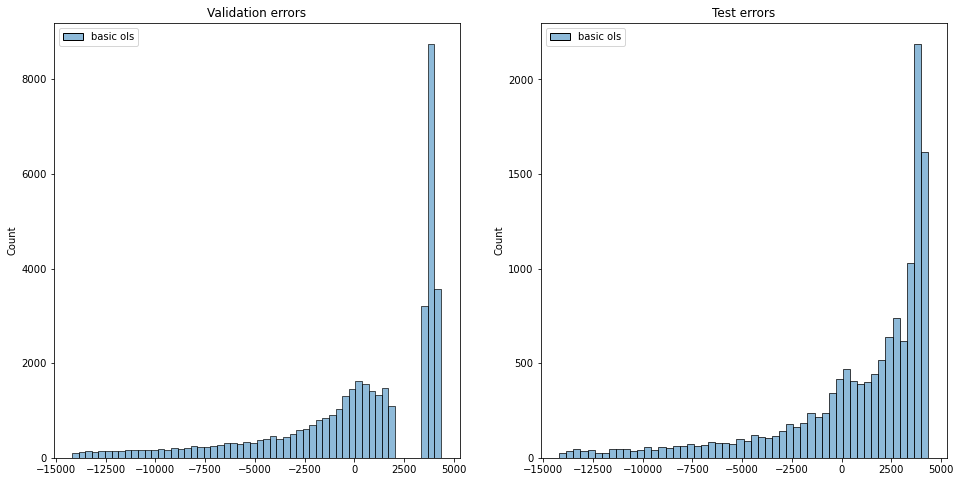

In [84]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['basic ols'], tt_errors['basic ols'] = get_errors(df, pipe, X, y)
sns.histplot(cv_errors, log_scale=False, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=False, ax=ax[1]).set_title('Test errors')

In [85]:
## Allow prices to be quadratic in carats: price ~ b0 + b1*carat * b2*carat^2 + e

y = ['price']
X = ['carat']

pipe = Pipeline([
    ('pol', PolynomialFeatures(2)),
    ('ols', LinearRegression(fit_intercept=True))
])

cross_validate(data=df, endog=y, exog=X, model=pipe)

Cross-validation results: mae = 953.98, stdev_err = 1211.06


Text(0.5, 1.0, 'Test errors')

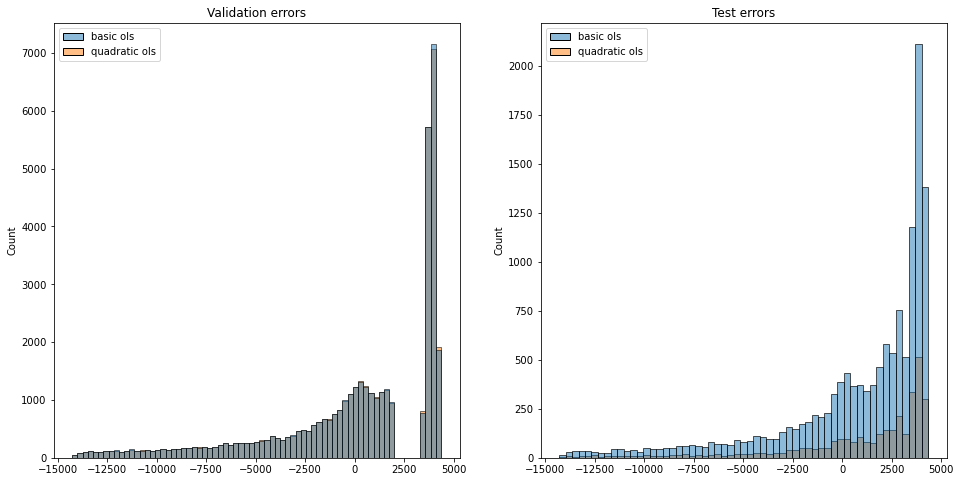

In [86]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['quadratic ols'], tt_errors['quadratic ols'] = get_errors(df, pipe, X, y)
sns.histplot(cv_errors, log_scale=False, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=False, ax=ax[1]).set_title('Test errors')

In [87]:
## Regression with dummies for categories: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies = df.drop(['cut','color','clarity'], axis='columns')\
    .join(pd.get_dummies(df.cut, drop_first=True))\
    .join(pd.get_dummies(df.color, drop_first=True))\
    .join(pd.get_dummies(df.clarity, drop_first=True))

y = ['price']
X = [col for col in df_dummies.columns if col != 'price']

pipe = Pipeline([
    ('pol', PolynomialFeatures(2)),
    ('ols', LinearRegression(fit_intercept=True))
])

cross_validate(data=df_dummies, endog=y, exog=X, model=pipe)

Cross-validation results: mae = 486.39, stdev_err = 604.95


Text(0.5, 1.0, 'Test errors')

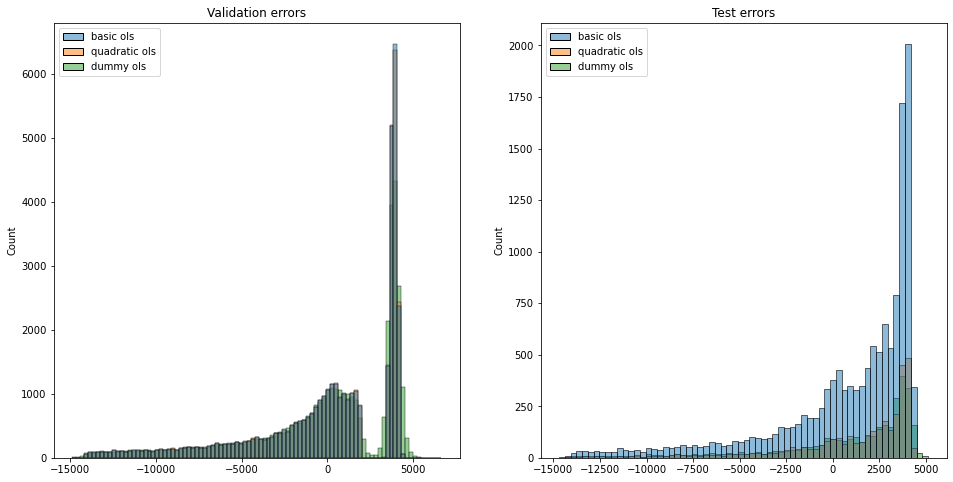

In [89]:
fig, ax = plt.subplots(1,2, figsize=(16,8))

cv_errors['dummy ols'], tt_errors['dummy ols'] = get_errors(df_dummies, pipe, X, y)
sns.histplot(cv_errors, log_scale=False, ax=ax[0]).set_title('Validation errors')
sns.histplot(tt_errors, log_scale=False, ax=ax[1]).set_title('Test errors')

In [ ]:
## Random forest reg

# df_rf = df.copy()
#
# for col in ['cut', 'clarity', 'color']:
#     df_rf[col] = df_rf[col].cat.codes
#
# y = ['price']
# X = [col for col in df_dummies.columns if col != 'price']
#
# pipe = Pipeline([
#     ('pol', PolynomialFeatures(2)),
#     ('rfr', RandomForestRegressor(n_estimators = 10, max_depth = 10))
# ])
#
# cross_validate(data=df_dummies, endog=y, exog=X, model=pipe)